In [1]:
# load necessary libraries
%matplotlib inline
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','source'))
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pp
from utils import df_par # for parallelization

In [2]:
data_dir = os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','data','flight_data')
misc_data_dir = os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','data','misc')
# Before importing data, let's define datatypes of columns
types = {0: 'int8', 1: 'category', 2: 'category', 3: 'int16', 4: 'int16', 5: 'int32',
         6: 'int16', 7: 'int32', 18: 'bool', 19: 'int8', 20: 'bool', 24: 'int16',
         25: 'int16', 26: 'int16', 27: 'int16', 28: 'int16', 29: 'int16', 31: 'float32',
         32: 'float32', 33: 'float32', 34: 'float32', 35: 'float32', 36: 'float32', 
         37: 'float32', 38: 'float32', 39: 'float32', 40: 'float32', 41: 'float32', 
         42: 'float32', 43: 'float32', 44: 'float32'}
# Now, import the data
flights = pd.read_csv(os.path.join(data_dir,'2018_final.csv'), usecols=range(0,45), dtype=types, parse_dates=[8, 9, 12, 13, 15, 16])
# Load airline codes and name
airlines = pd.read_csv(os.path.join(misc_data_dir,'airline.csv'), usecols=[1,3])
airlines = airlines.drop_duplicates(subset='CARRIER', keep='last')
airlines.columns = ['Code', 'CarrierName']
# Load airport data
airport = pd.read_csv(os.path.join(misc_data_dir,'airport.csv'), usecols = [0, 1, 2, 3, 4, 5, 6, 11, 16, 17])
airport.columns = ['AirID', 'Code', 'Name', 'City', 'Country', 'State', 'CityMarketID', 'Lat', 'Long', 'UTC']
airport = airport.drop_duplicates(subset='AirID', keep='last')

In [3]:
# Now, we need assign timedelta type to the columns listed below (in parallel)
cols = ['DepDelay', 'TxO', 'TxI', 'ArrDelay', 'ScElaTime', 'AcElaTime', 'AirTime', 'TimeZoneDiff']
for name in cols:
    flights.loc[:, name] = df_par(flights.loc[:, name], pd.to_timedelta)

### Poisson Distribution

Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event. The Poisson distribution can also be used for the number of events in other specified intervals such as distance, area or volume.

In this example, we will investigate poisson model for flight from Atlanta Hartsfield Airport where number of successful events would be number of delayed flights. To satify assumptions of poisson model, independence, homogenity, and fixed time, we will divide time of the day first into 7 categories. Assuming that one delayed event does not affect the next event, we can compute number of delayed flights, which is $\lambda$ ($np$) in the following code.

In [4]:
# 10397 Atlanta Airport Code
atl_flights = flights[flights.OrgAirID == 10397]
atl_flights = atl_flights[atl_flights.WeekDay == 1]
atl_flights.set_index('ScDepTime', drop=False, inplace=True)
atl_flights['Type'] = np.nan
labels = ['Early Morning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night']
atl_flights.iloc[atl_flights.index.indexer_between_time('04:00', '07:00', include_end=False), -1] = labels[0]
atl_flights.iloc[atl_flights.index.indexer_between_time('07:00', '11:00', include_end=False), -1] = labels[1]
atl_flights.iloc[atl_flights.index.indexer_between_time('11:00', '14:00', include_end=False), -1] = labels[2]
atl_flights.iloc[atl_flights.index.indexer_between_time('14:00', '18:00', include_end=False), -1] = labels[3]
atl_flights.iloc[atl_flights.index.indexer_between_time('18:00', '21:00', include_end=False), -1] = labels[4]
atl_flights.iloc[atl_flights.index.indexer_between_time('21:00', '23:59', include_end=True), -1] = labels[5]
atl_flights.iloc[atl_flights.index.indexer_between_time('00:00', '04:00', include_end=False), -1] = 'Late Night'

In [5]:
atl_flights.groupby(atl_flights.DepDelay >= pd.Timedelta('15 min'))['Type'].value_counts().unstack()

Type,Afternoon,Early Morning,Evening,Morning,Night,Noon
DepDelay,,,,,,
False,11646,1386,6906,13491,6224,8338
True,2947,104,2456,1646,2126,1671


From table above, one can say that maximum number of flight operations performed between 07:00AM - 11:00AM.

In [6]:
grouped = atl_flights.groupby([atl_flights.ScDepTime.dt.week, 'Type'])['DepDelay']
atl_poisson = np.empty((52,len(labels)))
for j, label in enumerate(labels):
    for i in range(1,53):
        temp = grouped.get_group((i, label))
        atl_poisson[i-1, j] = sum(temp >= pd.Timedelta('15 min'))

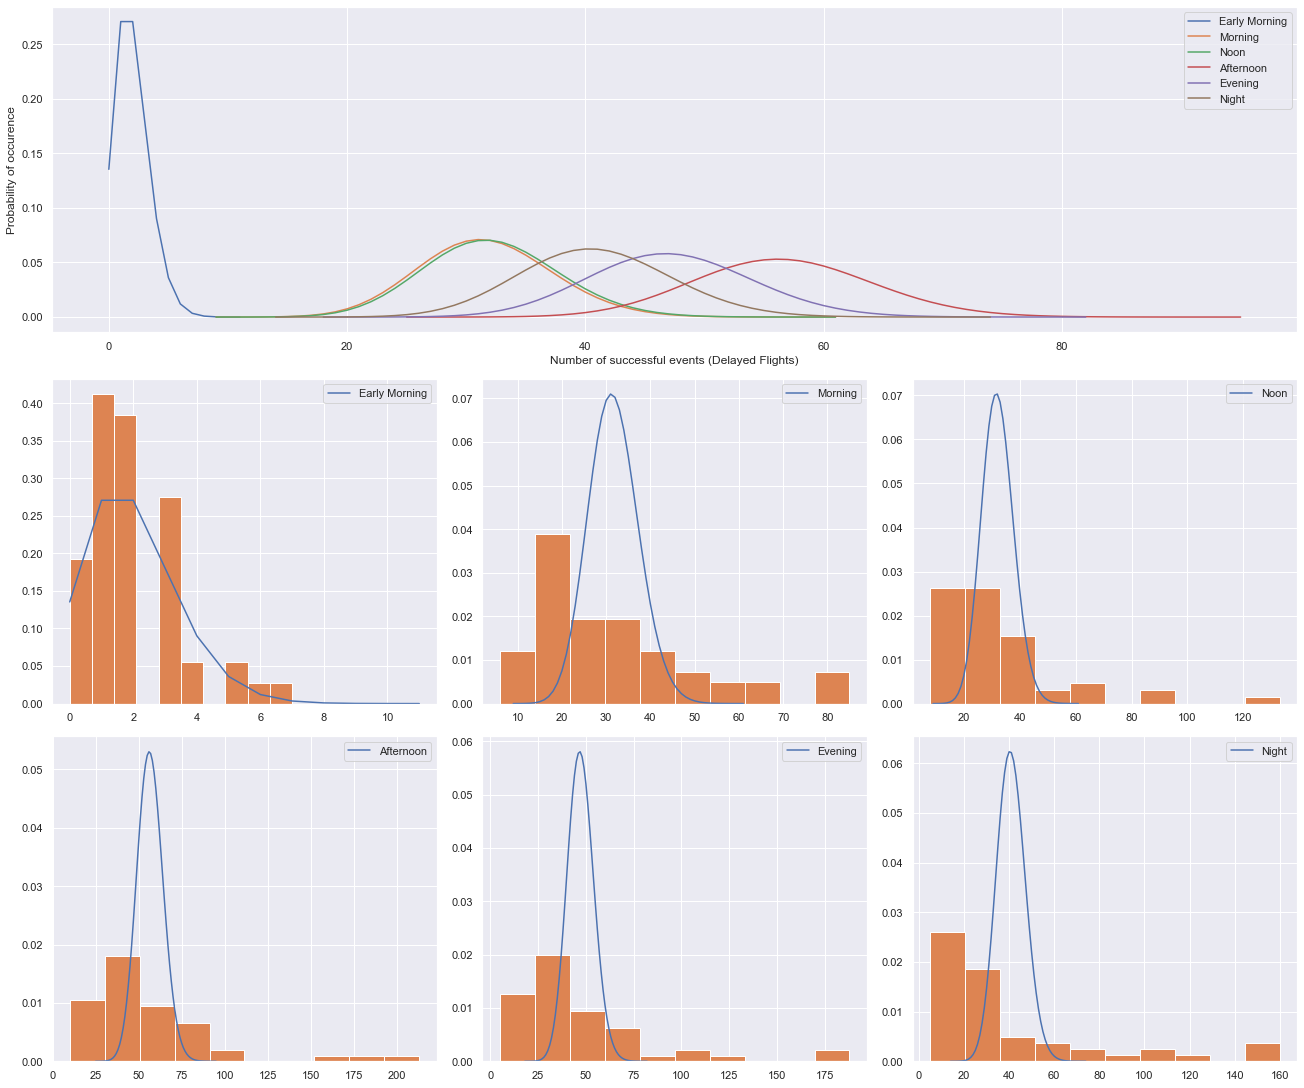

In [7]:
import matplotlib.gridspec as gridspec
from scipy.stats import poisson
sns.set()

fig = pp.figure(figsize=(18, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
big_ax = fig.add_subplot(spec[0, :])
axs = [fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 1]), fig.add_subplot(spec[1, 2]), 
       fig.add_subplot(spec[2, 0]), fig.add_subplot(spec[2, 1]), fig.add_subplot(spec[2, 2])]
labels = ['Early Morning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night']
mu = np.mean(atl_poisson, axis=0)
for idx, val in enumerate(mu):
    x = np.arange(poisson.ppf(0.000001, val), poisson.ppf(0.999999, val))
    _ = sns.lineplot(x, poisson.pmf(x, val), label=labels[idx], ax=big_ax)
_ = big_ax.set_xlabel('Number of successful events (Delayed Flights)')
_ = big_ax.set_ylabel('Probability of occurence')

for idx, ax in enumerate(axs):
    x = np.arange(poisson.ppf(0.000001, mu[idx]), poisson.ppf(0.999999, mu[idx]))
    _ = sns.lineplot(x, poisson.pmf(x, mu[idx]), label=labels[idx], ax=ax)
    _ = ax.hist(atl_poisson[:, idx], density=True)

Based on six different poisson models, one can conclude that only early morning flights better represents poisson model. Estimating number of delayed flights during other time of the day can be predicted using different models such as normal, lognormal, an exponential.

### Hypothesis Testing

In this example, we will compare departure delay distributions of morning flights on Monday between Los Angeles Airport (LAX) and Atlanta-Hartsfield Airport (ATL) using t-test. The null hypothesis is that average amount of delay is equal or that difference in average amount of delay is statistically not significant.

In [8]:
# 12892 Los Angeles Airport Code
lax_flights = flights[(flights.OrgAirID == 12892) & (flights.Cncl==0) & (flights.Div==0)]
atl_flights = atl_flights[(atl_flights.Cncl==0) & (atl_flights.Div==0)]
lax_flights = lax_flights[lax_flights.WeekDay == 1]
lax_flights.set_index('ScDepTime', drop=False, inplace=True)
t1 = lax_flights.iloc[lax_flights.index.indexer_between_time('07:00', '11:00', include_end=True)].DepDelay.astype('timedelta64[m]')
t2 = atl_flights.iloc[atl_flights.index.indexer_between_time('07:00', '11:00', include_end=True)].DepDelay.astype('timedelta64[m]')

Data shapes are different as expected. We are going to perform t-test from 5000 resamples to compare two distributions with the same size

In [9]:
print(t1.shape, t2.shape)

(9503,) (15309,)


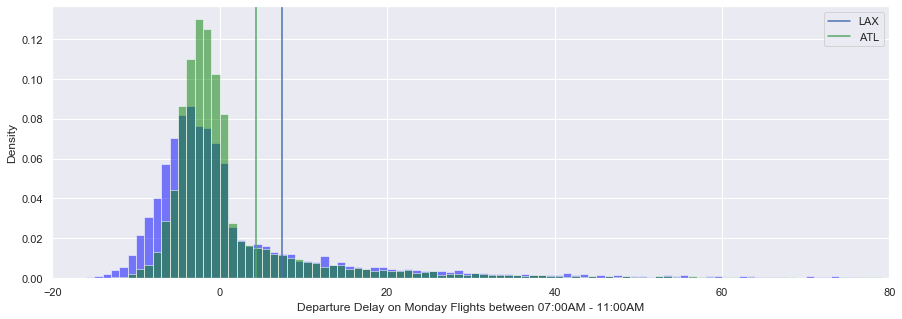

In [10]:
fig, ax = pp.subplots(figsize=(15,5))
_ = ax.hist(t1, bins=np.arange(-20, 80), density=True, alpha=0.5, color='blue')
_ = ax.set_xlim([-20, 80])
_ = ax.hist(t2, bins=np.arange(-20, 80), density=True, alpha=0.5, color='green')
_ = pp.axvline(x=t1.mean(), ymin=0, ymax=1, color='b')
_ = pp.axvline(x=t2.mean(), ymin=0, ymax=1, color='g')
_ = pp.legend(['LAX','ATL'])
_ = ax.set_xlabel('Departure Delay on Monday Flights between 07:00AM - 11:00AM')
_ = ax.set_ylabel('Density')

The green distribution, ATL, looks shifted to the right and its peak is higher around zero. This can be explained by number of flights since ATL has more flight operations than LAX. The green and blue bars show theoretical mean of ATL and LAX correspondingly.

In [11]:
t1.mean(), t2.mean() # Theoretical means

(7.4264968957171416, 4.383434580965445)

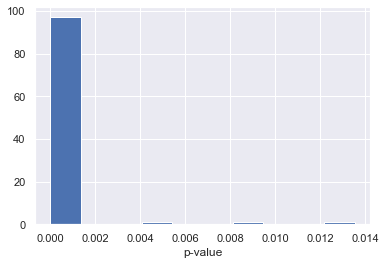

In [12]:
from scipy.stats import ttest_ind
p = np.empty([100])
t = np.empty([100])
for i in range(100):
    t[i], p[i] = ttest_ind(t1.sample(5000), t2.sample(5000), equal_var=False)
_ = pp.hist(p)
_ = pp.xlabel('p-value')

T-test is performed with 5000 resamples 100 times. All samples show that p-value is smaller than significance level, 0.05 (95%). Therefore, we reject null-hypothesis which is that means of two distributions are equal or that the difference in means of two distributions are not significant.